<h1>Inventory Monitoring at Distribution Centers using CNNs</h1>

Inventory Monitoring at Distribution Centers is an important task for some companies in charge of delivering packages. When you order something from Amazon they need to make sure that they are delivering all the product items you ordered within a single package, nothing more and nothing less.

This project uses the <a href='https://registry.opendata.aws/amazon-bin-imagery/'>Amazon Bin Image Dataset</a> that contains images of orders together with the amount of products that are in every order. The dataset contains 500K images but only a subset of them are used here to train a model using ConvNets. The objective of this project is to build a classifier that receives an image of an order with the products in it and it tries to guess how many products there are. Also, this project illustrates mainly how to train/evaluate/deploy a model in Sagemaker to be ready to be used for making predictions via an endpoint.

<h3>Install and import</h3>

Some libraries need to be installed first in order to execute this notebook without any issue.

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm smdebug

In [75]:
import os
import io

import random
import boto3
import sagemaker
import numpy as np
import requests
import json
from tqdm import tqdm
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
import matplotlib.pyplot as plt
from PIL import Image

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import boto3
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

import IPython

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer

In [49]:
s3_client = boto3.client('s3')
bucket_name = 'sagemaker-us-east-1-272259209865'
s3_ds_directory = 'AmazonBinImageDataset'
role = sagemaker.get_execution_role()
session = boto3.session.Session()
region = session.region_name

# Dataset

The dataset can be downloaded from the AWS S3 public bucket: `S3://aft-vbi-pds/bin-images/`. The file names for the pictures are found in the `file_list.json` file which contains a dictionary in the format of: 

```
{
'number_of_objects': [
    'img1.jpg', 
    'img2.jpb',
    ...
    ]
}
```

This json file will be used to download the images. It is important to notice that this project works with a small portion of the entire dataset because the time that the model takes to train is proportional to the amount of data we feed it with. Eventhough accuracy is going to be affected with that decission.

Before downloading the dataset three dictionaries are created: `train|test|val` that represent the training, testing, and validation dataset accordingly. Each of them will contain metadata information about what images should belong to each dataset. Also, it is important to mention that 70%/20%/10% of the data goes to the `train/test/val` datasets.

<h3>Get the data and copy it to S3</h3>

In [118]:
def define_train_test_val_ds(json_file='file_list.json'):
    with open(json_file, 'r') as f:
        d=json.load(f)

    train = {}
    test = {}
    val = {}
    for k, v in d.items():
        samples = len(v)
        _70_perc = int(samples*0.7)
        _90_perc = int(samples*0.9)
        train[k] = v[:_70_perc]
        test[k] = v[_70_perc:_90_perc]
        val[k] = v[_90_perc:]
    return train, test, val

def print_size_of_ds(ds, name):
    print(name,':')
    for k, v in ds.items():
        print('\t',k,'object(s)  ->', len(v), 'images')
        
def download_images(ds, name):
    for k, v in ds.items():
        print(f"Downloading Images with {k} objects")
        directory= os.path.join(name, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))
            
def upload_directory_to_s3(local_directory, s3_bucket, s3_prefix=''):
    for root, dirs, files in os.walk(local_directory):
        for file in tqdm(files):
            local_path = os.path.join(root, file)
            s3_path = os.path.join(s3_prefix, local_path).replace("\\", "/")
            s3_client.upload_file(local_path, s3_bucket, s3_path)
    print('upload complete')

def plot_number_images(ds, name, ax, plot_n):

    n_objects = [k for k,v in ds.items()]
    counts = [len(v) for k,v in ds.items()]

    ax[plot_n].bar(n_objects, counts)

    ax[plot_n].set_ylabel('Number of Images')
    ax[plot_n].set_xlabel('Number of Object in Image')
    ax[plot_n].set_title(f'{name}')

Here are the number of samples per class and per dataset:

In [77]:
train, test, val = define_train_test_val_ds()
print_size_of_ds(train, 'train')
print_size_of_ds(test, 'test')
print_size_of_ds(val, 'val')

train :
	 1 object(s)  -> 859 images
	 2 object(s)  -> 1609 images
	 3 object(s)  -> 1866 images
	 4 object(s)  -> 1661 images
	 5 object(s)  -> 1312 images
test :
	 1 object(s)  -> 246 images
	 2 object(s)  -> 460 images
	 3 object(s)  -> 533 images
	 4 object(s)  -> 474 images
	 5 object(s)  -> 375 images
val :
	 1 object(s)  -> 123 images
	 2 object(s)  -> 230 images
	 3 object(s)  -> 267 images
	 4 object(s)  -> 238 images
	 5 object(s)  -> 188 images


Here is a more intuitive way of showing the exact same information:

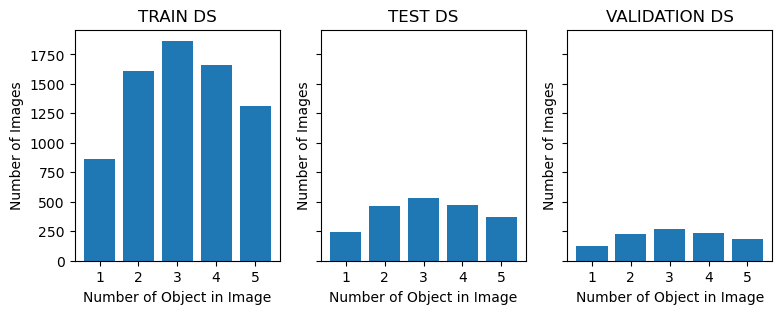

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
plot_number_images(train, 'TRAIN DS', axs, 0)
plot_number_images(test, 'TEST DS', axs, 1)
plot_number_images(val, 'VALIDATION DS', axs, 2)

The images show that there are 5 classes (1,2,3,4,5) that represent how many objects are supposed to be in the order (in the picture).

It is important to notice that the number of images that contains a single object is less than the images of objects that contains 3 objects. Eventhough every class does not contain the same number of samples, the difference is not very significant. In order to have a better classifier we could download more images so that the total number of images per class is the same among the rest.

### Download data to local instance

Now that the `train|test|val` dictionaries are created, they can be used to download the images in their directories such as follows:

`dataset/`

```
train/
    1/
        img1.jpg
        img2.jpg
        img3.jpg
        ...
    2/
        img1.jpg
        img2.jpg
        img3.jpg
        ...
    ...
    5/
        img1.jpg
        ...
test/
    1/
        img1.jpg
        ...
    ...
    5/
        img1.jpg
        ...
val/
    1/
        img1.jpg
        ...
    ...
    5/
        img1.jpg
        ...
```

In [101]:
download_images(train, 'train')

100%|██████████| 859/859 [01:11<00:00, 11.96it/s]


100%|██████████| 1609/1609 [02:16<00:00, 11.79it/s]


100%|██████████| 1866/1866 [02:41<00:00, 11.53it/s]


100%|██████████| 1661/1661 [02:20<00:00, 11.83it/s]


100%|██████████| 1312/1312 [01:50<00:00, 11.92it/s]


In [102]:
download_images(test, 'test')

100%|██████████| 246/246 [00:19<00:00, 12.39it/s]


100%|██████████| 460/460 [00:38<00:00, 11.83it/s]


100%|██████████| 533/533 [00:46<00:00, 11.45it/s]


100%|██████████| 474/474 [00:38<00:00, 12.25it/s]


100%|██████████| 375/375 [00:29<00:00, 12.56it/s]


In [ ]:
download_images(val, 'valid')

100%|██████████| 123/123 [00:09<00:00, 12.89it/s]


100%|██████████| 230/230 [00:19<00:00, 11.53it/s]


100%|██████████| 267/267 [00:22<00:00, 12.01it/s]


100%|██████████| 188/188 [00:14<00:00, 12.88it/s]


### Upload data to S3

Now that the dataset is downloaded into our local instance, it can be upload to S3. Thus, the instances created for job training or hyperparameter tuning can access to it directly.

In [119]:
upload_directory_to_s3('train', bucket_name, s3_ds_directory)

0it [00:00, ?it/s]
100%|██████████| 1866/1866 [02:25<00:00, 12.80it/s]

upload complete


In [120]:
upload_directory_to_s3('test', bucket_name, s3_ds_directory)

0it [00:00, ?it/s]
100%|██████████| 533/533 [00:40<00:00, 13.24it/s]

upload complete


In [121]:
upload_directory_to_s3('valid', bucket_name, s3_ds_directory)

0it [00:00, ?it/s]
100%|██████████| 267/267 [00:20<00:00, 13.04it/s]

upload complete


### Download some samples form S3

Once the data is stored in S3, some samples can be downloaded to see how they look like together with their label (number of objects).

In [106]:
def download_img(path):
    s3_client.download_file(bucket_name, f'{s3_ds_directory}/{path}', 'test.jpg')
    Image.open('test.jpg').show()
    print('Label:',path.split('/')[1])

Here are three pictures with 3 and 1 objects on it.

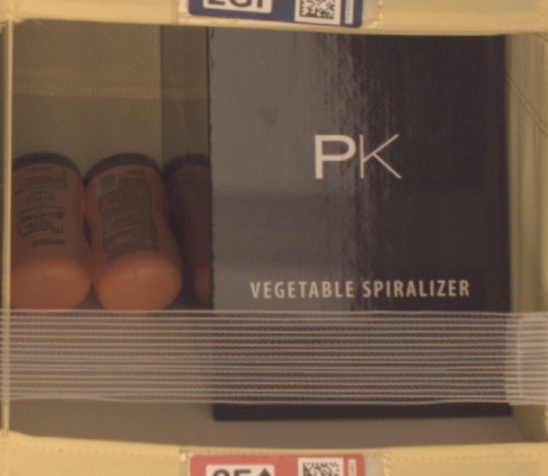

Label: 3


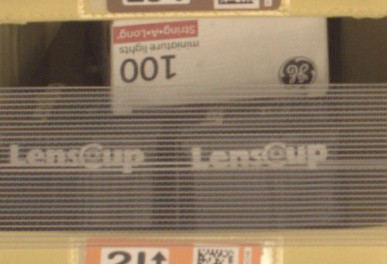

Label: 3


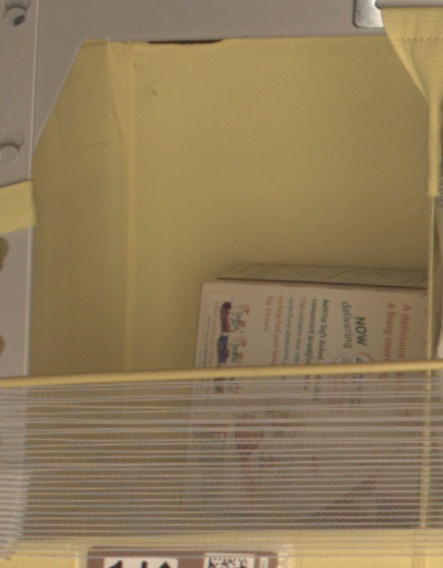

Label: 1


In [112]:
download_img('train/3/00085.jpg')
download_img('test/3/01572.jpg')
download_img('train/1/00989.jpg')

It is also important to notice that not all the pictures are clear and for some of them it is even difficult to notice how many objects are on them because they are plastic bags or an object covers all the rest of objects.

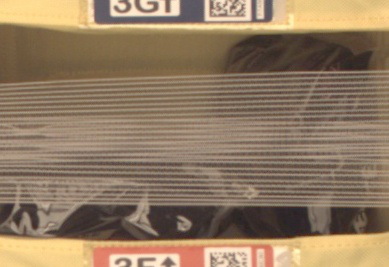

Label: 2


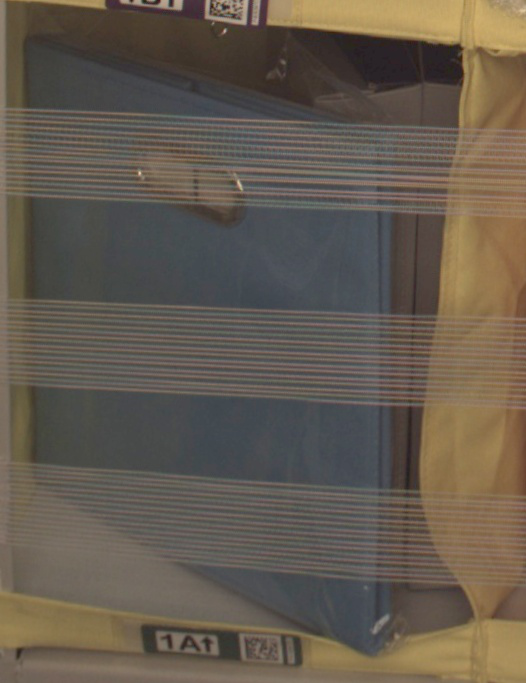

Label: 3


In [115]:
download_img('valid/2/04713.jpg')
download_img('train/3/00141.jpg')

Some other examples are blurry or have a bad image quality as in the first picture and some others are not correctly labeled as in the second picture that has two objects but it has a label of one.

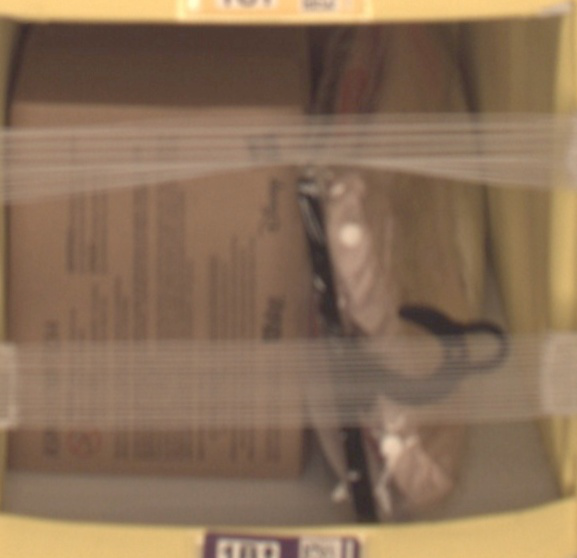

Label: 3


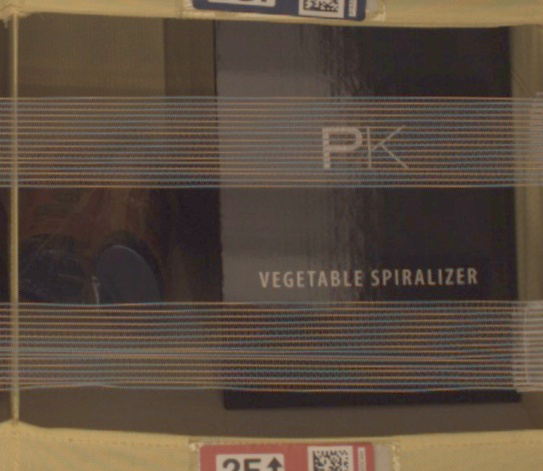

Label: 1


In [120]:
download_img('train/3/01925.jpg')
download_img('train/1/00084.jpg')


Some other images are not very well centered and it appears a hook on it that can affect prediction cause it can be recognized as another object.

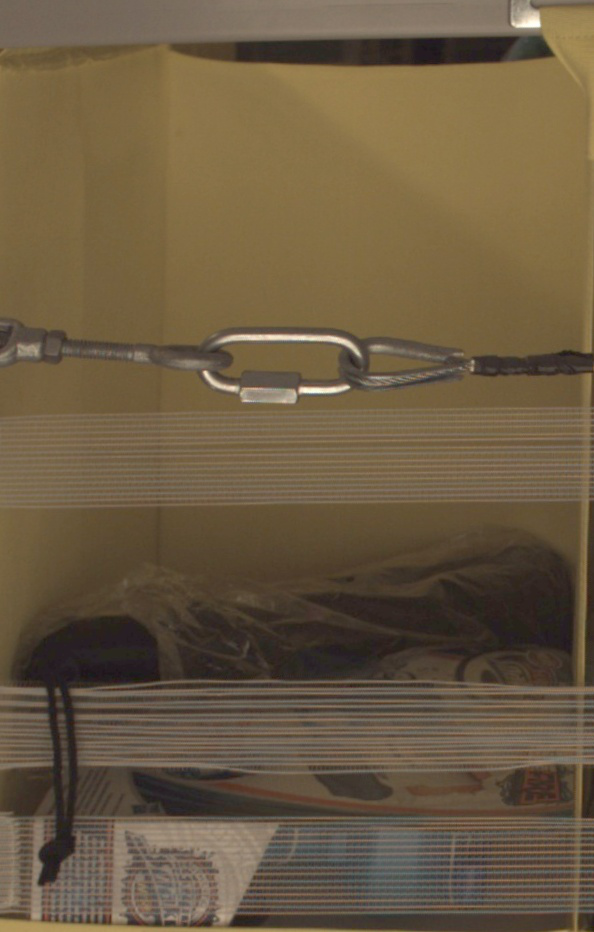

Label: 2


In [121]:
download_img('train/2/00835.jpg')

As it can be seen above, the dataset has some problems and for some images even a human may have difficulties trying to guess how many objects there are on them. A manual cleaning and preprocess of every image is needed so the dataset can led to a more accurate model which is out of the scope of this project.

### Data transformation

The images are first transformed before training the model. They are resized to 112x112 pixels and rotated randomly for the training dataset. There is no need to rotate the images for the test and validation dataset but they are as well resized to be 112x112 pixels.

# Hyperparameter Tuning

The script that will be executed for hyperparameter tuning can be found here: `src/hpo.py`. The model used is a pretrained ResNet50 model that uses transfer learning to add three more layers: 

- Fully Connected Layer: with 2048 neurons
- Fully Connected Layer: with 128 neurons
- Fully Connected Layer (output layer): with 5 neurons one for each class

Two parameters are tuned: learning rate and batch size. The first one may take any value between 0.001 and 0.1 and the second one may take any of these specific values 32, 64, 128, 256, 512.

The instance where the training will happen is an ml.g4dn.xlarge which contains a GPU to accelerate the training. Also, 4 jobs will be created and all of them will run in parallel to save time (but not money). 

The metric used for assess the classifier is the accuracy and is the one that will be sought to be maximized. 

The accuracy is defined as follows:

$Accuracy = \frac{Number Of Corrected Predictions}{Total Number Of Predictions}\times 100\%$

<h3>Set up parameters, estimator, and tuner</h3>

In [31]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Test Accuracy", "Regex": "Testing Accuracy: ([0-9\\.]+)"}]

In [32]:
estimator = PyTorch(
    entry_point="src/hpo.py",
    base_job_name='pytorch_aws_bin_objects_hpo',
    role=role,
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py36'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [33]:
os.environ['SM_CHANNEL_TRAINING']=f's3://{bucket_name}/{s3_ds_directory}'
os.environ['SM_MODEL_DIR']=f's3://{bucket_name}/{s3_ds_directory}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{bucket_name}/{s3_ds_directory}/output/'
tuner.fit({"training": f"s3://{bucket_name}/{s3_ds_directory}"})

Using provided s3_resource


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


The best model used a batch size of 128 and a learning rate of 0.001241. It obtained a testing score of 32.41% which is better than a random classifier (20% of accuracy in average).

In [35]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230727-1612')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
1      "128"       0.001241  pytorch-training-230727-1612-003-0c2bf7be   
3       "32"       0.001855  pytorch-training-230727-1612-001-a9b3b9d7   
2       "32"       0.003248  pytorch-training-230727-1612-002-6392389c   
0      "128"       0.006151  pytorch-training-230727-1612-004-7090ab53   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
1         Completed            32.410000 2023-07-27 16:13:43+00:00   
3         Completed            31.840000 2023-07-27 16:13:40+00:00   
2         Completed            31.740000 2023-07-27 16:13:46+00:00   
0         Completed            29.540001 2023-07-27 16:13:50+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
1 2023-07-27 16:26:53+00:00                       790.0  
3 2023-07-27 16:26:05+00:00                       745.0  
2 2023-07-27 16:27:26+00:00                       820.0  
0 2023-07-27 16:26:29+00:00                       759.0

<h3>Prepare to perform Training on Best Estimator</h3>

Now it is time to train the model that will be further deployed and used to make some predictions. To see how well it does during training and also to check some performance metrics such as GPU/CPU utilization to make sure we are using the GPU instead of CPU, a debugger and a profiler can be attached to the estimator.

In [36]:
best_estimator=tuner.best_estimator()


2023-07-27 16:26:56 Starting - Preparing the instances for training
2023-07-27 16:26:56 Downloading - Downloading input data
2023-07-27 16:26:56 Training - Training image download completed. Training in progress.
2023-07-27 16:26:56 Uploading - Uploading generated training model
2023-07-27 16:26:56 Completed - Resource retained for reuse


In [58]:
#best_estimator=tuner.best_estimator()
BetterTrainingJobName='pytorch-training-230727-0426-004-ce5f19f6'
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
my_estimator.hyperparameters()
best_estimator=my_estimator


2023-07-27 04:40:15 Starting - Preparing the instances for training
2023-07-27 04:40:15 Downloading - Downloading input data
2023-07-27 04:40:15 Training - Training image download completed. Training in progress.
2023-07-27 04:40:15 Uploading - Uploading generated training model
2023-07-27 04:40:15 Completed - Resource reused by training job: pytorch-training-230727-0426-007-c8964bc2


In [37]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Accuracy"',
 'batch_size': '"128"',
 'learning_rate': '0.0012414040521251516',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_aws_bin_objects_hpo-2023-07-27-16-12-12-871"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-284429595136/pytorch_aws_bin_objects_hpo-2023-07-27-16-12-12-871/source/sourcedir.tar.gz"'}

In [38]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 128, 'learning_rate': '0.0012414040521251516'}

In [39]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [40]:
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_hook_config = DebuggerHookConfig(collection_configs=collection_configs)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


<h2>Train Model with best Hyperparameters found</h2>

Again, a ml.g4dn.xlarge instance is used to perform the training and it is done asynchronously to avoid waiting in the console. The script used for model training is under the `src/train.py` file. It is a slightly modified version of the `hpo.py` script because it attaches the debugger/profiler hooks. Additionally, to do multi-instance training it just suffices to modify the instance count to be more than 1. 

In an effort to improve accuracy many things were tested out such as resizing the images to 224x224 instead of 112x112, centering them, croping them, trying data augmentation making a rotation of the images, modifying the architecture to include more or less layers, adding a dropout layer to avoid overfitting, etc. Unfortunately, none of these techniques made a lot of improvement in the final model.

In [46]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='src/train.py',
    base_job_name='pytorch-aws-bin-objects-train',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.8',
    py_version='py36',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
)

In [47]:
estimator.fit({"training": f"s3://{bucket_name}/{s3_ds_directory}"}, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: pytorch-aws-bin-objects-train-2023-07-27-17-49-13-721


## Model Profiling and Debugging

After training the model, the profiling data will be available and GPU/CPU metrics can be visualized in order to see that the code run under GPU and check the correct consumption of both.

Some picks are well appreciated under the GPU utilization plot that indicates that GPU was heavily used. In order to avoid these picks, the size of the tensors may be reduced either by reducing the batch or image size; otherwise, a larger instance may be selected which can envolve more costs as well.

In [50]:
def plot_cpu_gpu_use(training_job_name):
    
    tj = TrainingJob(training_job_name, region)
    tj.wait_for_sys_profiling_data_to_be_available()

    system_metrics_reader = tj.get_systems_metrics_reader()
    system_metrics_reader.refresh_event_file_list()

    view_timeline_charts = TimelineCharts(
        system_metrics_reader,
        framework_metrics_reader=None,
        select_dimensions=["CPU", "GPU"],
        select_events=["total"],
    )

plot_cpu_gpu_use(estimator.latest_training_job.name)

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-284429595136/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-284429595136/pytorch-aws-bin-objects-train-2023-07-27-17-49-13-721/profiler-output


Profiler data from system is available
[2023-07-27 18:19:11.462 ip-172-16-43-232.ec2.internal:1025 INFO metrics_reader_base.py:134] Getting 22 event file

[2023-07-27 18:19:46.472 ip-172-16-43-232.ec2.internal:1025 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-284429595136/pytorch-aws-bin-objects-train-2023-07-27-17-49-13-721/debug-output
[2023-07-27 18:19:46.798 ip-172-16-43-232.ec2.internal:1025 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 231 more expected)', IncompleteRead(0 bytes read, 231 more expected)) while reading s3://sagemaker-us-east-1-284429595136/pytorch-aws-bin-objects-train-2023-07-27-17-49-13-721/debug-output/index/000000000/000000000149_worker_0.json . Will retry now
[2023-07-27 18:19:51.133 ip-172-16-43-232.ec2.internal:1025 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-07-27 18:19:52.156 ip-172-16-43-232.ec2.internal:1025 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


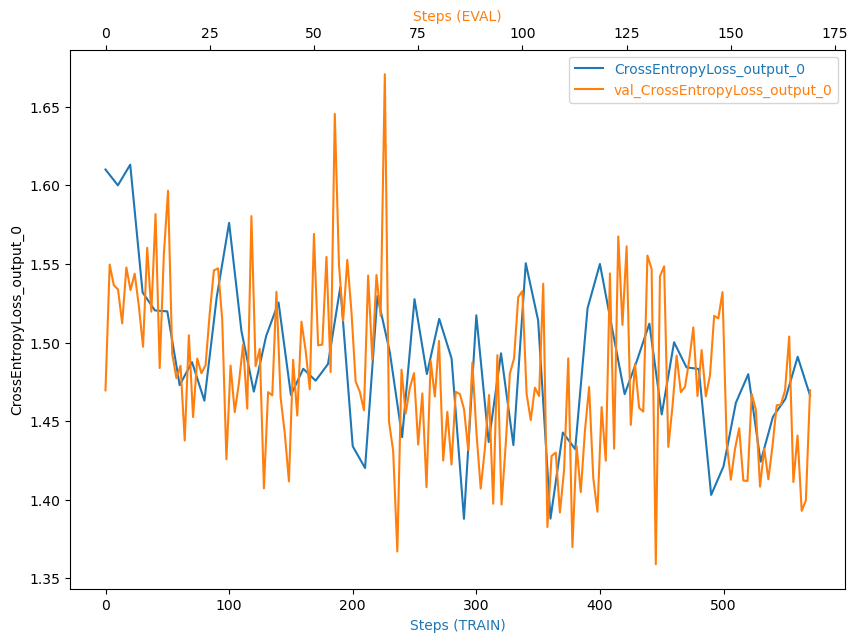

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
plot_tensor(trial, "CrossEntropyLoss_output_0")

The ploy above shows the loss for the training and validation datasets. A lot of picks are also present in the plot that may be associated with the difficulty of the model to learn. Many more epochs were also added for the model to have a better chance to improve but similar results were found. 

## Download Profiler Report and Display It

The profiler report shows that the GPU was saturated, this also was appreciated from the GPU Memory Utilization graph above and the solution may be increase the instance type to a larger one. Also, almos a quarter of the time of the job was spent in initializing. 

In [57]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-284429595136/pytorch-aws-bin-objects-train-2023-07-27-17-49-13-721/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-284429595136/pytorch-aws-bin-objects-train-2023-07-27-17-49-13-721/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-284429595136/pytorch-aws-bin-objects-train-2023-07-27-17-49-13-721/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-284429595136/pytorch-aws-bin-objects-train-2023-07-27-17-49-13-721/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-ea

In [58]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

<h2>Deployment</h2>

Now the model will be deployed into a Sagemaker endpoint for inference.

In [60]:
model_location=estimator.model_data

In [79]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [80]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='src/infernce2.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [84]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-284429595136/pytorch-aws-bin-objects-train-2023-07-27-17-49-13-721/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-284429595136/pytorch-inference-2023-07-27-21-45-07-954/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-07-27-22-03-33-041
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-07-27-22-03-33-724
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-07-27-22-03-33-724


-----!

## Prediction

Some predictions together with their labels are shown below:

In [99]:
predictor.serializer = IdentitySerializer("image/jpeg")
def make_pred(img_path=''):
    buf = io.BytesIO()
    img = Image.open(img_path)
    img_bytes = img.save(buf, format='JPEG')
    img.show()
    response=predictor.predict(buf.getvalue(), initial_args={"ContentType": "image/jpeg"})
    print('Prediction:', np.argmax(response)+1)
    print('Actual Label:', img_path.split('.')[0][-1])

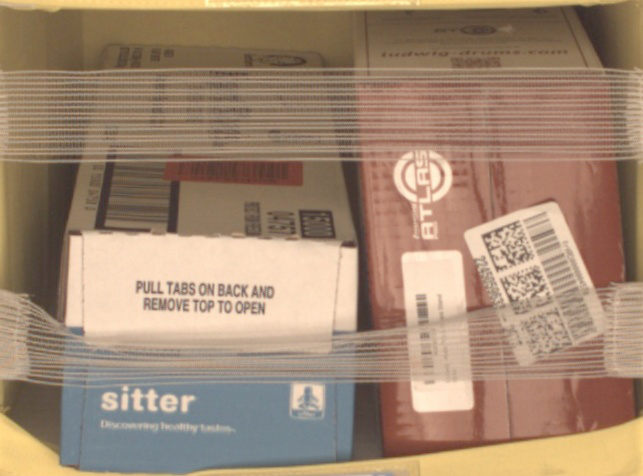

Prediction: 3
Actual Label: 1


In [102]:
make_pred('img_tests_pred/06638_1.jpg')

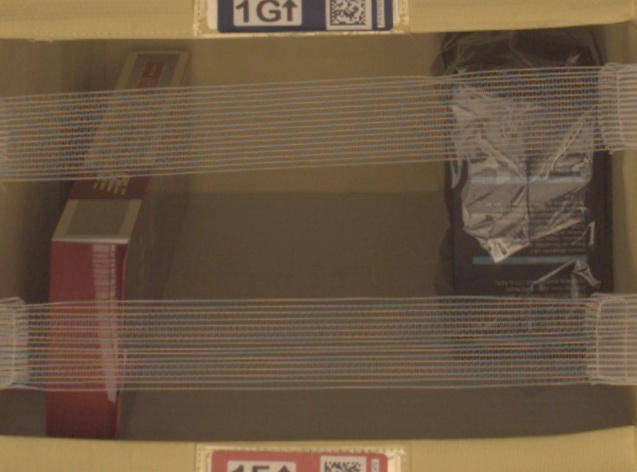

Prediction: 3
Actual Label: 2


In [103]:
make_pred('img_tests_pred/00870_2.jpg')

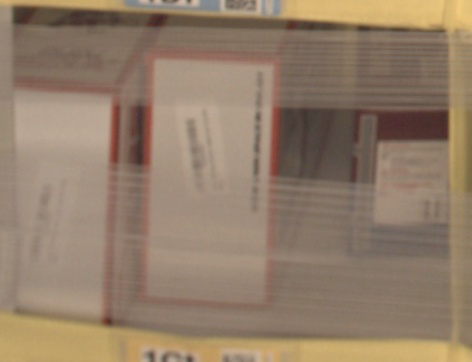

Prediction: 5
Actual Label: 3


In [104]:
make_pred('img_tests_pred/06098_3.jpg')

In [ ]:
response2[0]

# Conclusion

Sagemaker is not an easy to use tool. It is a tool that evolves in time and many things that used to work in the past are going to be deprecated soon. The documentaion is complete enough but the examples provided does not work all the time.

This project presented a lot of difficulties to obtain a final-ready-to-use model because the accuracy of the model presented is low and it may not be sufficient to move it to a production-ready environment. Further work needs to be done to have a better model such as the use of more images from the dataset, more experimentation with some other pretrained models, some more architecture, the use of more hyperparameters, etc. Nevertheless, the present project has accomplished its purpose which is show how to have a model togheter to the end-to-end process needed using AWS resources and tools. 

It was a very fun project and I enjo